一个打车订单分配问题，假设有一个乘客rider集合R ,一个司机driver的集合D , 我们考虑顾客数量和司机数量相等的情况，来将顾客和司机进行一对一的匹配，这个问题可以建模为一个整数规划Integer Programming，但是这个问题非常特殊，将binary constraints松弛掉，依然存在整数最优解。

In [1]:
from gurobipy import *
import pandas as pd 
import numpy as np 
import random 

In [2]:
# generate matching value matrix
order_num = 20   
profit_matrix = np.zeros((order_num, order_num))
for i in range(order_num):
    for j in range(order_num):
        if(i == j):
            profit_matrix[i][j] = 0
        else:
            random.seed(i * order_num + j) 
            profit_matrix[i][j] = round(10 * random.random(), 1) 
profit_matrix  

array([[0. , 1.3, 9.6, 2.4, 2.4, 6.2, 7.9, 3.2, 2.3, 4.6, 5.7, 4.5, 4.7,
        2.6, 1.1, 9.7, 3.6, 5.2, 1.8, 6.8],
       [9.1, 0. , 9.6, 9.2, 7.1, 3.8, 7.5, 6.5, 1.1, 5.5, 5.4, 0.1, 0.8,
        5.7, 5.3, 5.5, 3.3, 6.8, 6.4, 2.1],
       [4.6, 3.8, 0. , 0.4, 4.1, 2.7, 8.9, 3.5, 5.5, 0.7, 5. , 2.4, 9.8,
        6.2, 9.1, 0.9, 9.7, 0.4, 5.8, 2.2],
       [3.1, 4.9, 9.3, 0. , 4.8, 4.1, 0.7, 0.7, 7.4, 6.8, 9.1, 3.2, 0.7,
        2.8, 8.6, 4.5, 3.7, 8. , 8.1, 1.5],
       [2.7, 5.1, 1.4, 5. , 0. , 2. , 7.9, 1.5, 4. , 0.8, 2. , 0.8, 4.2,
        9.1, 5.5, 7.6, 3.7, 1.9, 3.6, 4. ],
       [1.5, 5.8, 1.5, 9.8, 9.6, 0. , 7.1, 2.5, 1.3, 2.8, 9.3, 8.3, 4.8,
        0.3, 2.4, 9. , 8.2, 2.4, 7.1, 9.3],
       [5.1, 0.9, 5.1, 0.5, 9.6, 9. , 0. , 0.4, 9.4, 5.9, 5.2, 3.2, 4.1,
        4.9, 4.8, 6.7, 5.8, 0.7, 1.9, 0. ],
       [7.7, 5.2, 5.8, 9.1, 4.5, 8.7, 1.3, 0. , 4. , 0.7, 8.2, 7.1, 9.8,
        9.9, 2. , 5.8, 4.9, 6.1, 6.8, 3.9],
       [1.2, 5.2, 0.5, 5.4, 1. , 0.2, 1.8, 2.3, 0. , 2.6, 7.9, 7

In [3]:
P = pd.DataFrame(profit_matrix)
P 

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.0,1.3,9.6,2.4,2.4,6.2,7.9,3.2,2.3,4.6,5.7,4.5,4.7,2.6,1.1,9.7,3.6,5.2,1.8,6.8
1,9.1,0.0,9.6,9.2,7.1,3.8,7.5,6.5,1.1,5.5,5.4,0.1,0.8,5.7,5.3,5.5,3.3,6.8,6.4,2.1
2,4.6,3.8,0.0,0.4,4.1,2.7,8.9,3.5,5.5,0.7,5.0,2.4,9.8,6.2,9.1,0.9,9.7,0.4,5.8,2.2
3,3.1,4.9,9.3,0.0,4.8,4.1,0.7,0.7,7.4,6.8,9.1,3.2,0.7,2.8,8.6,4.5,3.7,8.0,8.1,1.5
4,2.7,5.1,1.4,5.0,0.0,2.0,7.9,1.5,4.0,0.8,2.0,0.8,4.2,9.1,5.5,7.6,3.7,1.9,3.6,4.0
5,1.5,5.8,1.5,9.8,9.6,0.0,7.1,2.5,1.3,2.8,9.3,8.3,4.8,0.3,2.4,9.0,8.2,2.4,7.1,9.3
6,5.1,0.9,5.1,0.5,9.6,9.0,0.0,0.4,9.4,5.9,5.2,3.2,4.1,4.9,4.8,6.7,5.8,0.7,1.9,0.0
7,7.7,5.2,5.8,9.1,4.5,8.7,1.3,0.0,4.0,0.7,8.2,7.1,9.8,9.9,2.0,5.8,4.9,6.1,6.8,3.9
8,1.2,5.2,0.5,5.4,1.0,0.2,1.8,2.3,0.0,2.6,7.9,7.8,3.5,3.2,8.0,4.4,0.3,9.7,9.5,9.0
9,1.4,5.8,4.5,1.1,2.8,9.0,3.4,3.5,7.9,0.0,0.7,7.6,3.7,5.6,8.1,6.0,6.5,5.4,0.5,3.4


In [4]:
# construct model object
model = Model('Assignment_Problem') 

# introduce decision variable by cycling 
x = [[[] for i in range(order_num)] for j in range(order_num)]  
for i in range(order_num):
    for j in range(order_num): 
        x[i][j] = model.addVar(lb = 0
                               ,ub = 1 
                               ,vtype = GRB.CONTINUOUS   # decision variable type
                               ,name = "x_" + str(i) + "_" + str(j)  
                               )
#         x[i][j] = model.addVar(vtype = GRB.BINARY   # decision variable type
#                                 ,name = "x_" + str(i) + "_" + str(j)  
#                                 )

# objective function
obj = LinExpr(0)

for i in range(order_num):
    for j in range(order_num): 
        obj.addTerms(profit_matrix[i][j], x[i][j])
 
model.setObjective(obj, GRB.MAXIMIZE)     

# Constraint 1
for j in range(order_num):
    expr = LinExpr(0)
    for i in range(order_num):  
        expr.addTerms(1, x[i][j]) 
    model.addConstr(expr == 1, name="D_" + str(i)) 
        
# Constraint 2
for i in range(order_num):
    expr = LinExpr(0)
    for j in range(order_num):  
        expr.addTerms(1, x[i][j]) 
    model.addConstr(expr == 1, name="R_" + str(i)) 

# solve the constructed model
model.write('model.lp')
model.optimize()

# print optimal solution 
for var in model.getVars():
    if(var.x > 0):
        print(var.varName, '\t', var.x)  

Using license file E:\Anaconda3\win64\gurobi.lic
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 40 rows, 400 columns and 800 nonzeros
Model fingerprint: 0x4f6b3c13
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-01, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.04s
Presolved: 40 rows, 400 columns, 800 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.8840000e+02   1.500000e+01   0.000000e+00      0s
       9    1.8650000e+02   0.000000e+00   0.000000e+00      0s

Solved in 9 iterations and 0.09 seconds
Optimal objective  1.865000000e+02
x_0_15 	 1.0
x_1_0 	 1.0
x_2_16 	 1.0
x_3_10 	 1.0
x_4_13 	 1.0
x_5_19 	 1.0
x_6_4 	 1.0
x_7_12 	 1.0
x_8_18 	 1.0
x_9_5 	 1.0
x_10_17 	 1.0
x_11_8 	 1.0
x_12_3 	 1.0
x_13_6 	 1.0
x_14_9 	 1.0
x_15_2 	 1.0
x_16_7 	 1.0
x_17_11 	 1.0
x

# 带时间窗的车辆路径规划问题(Vrptw)

https://mp.weixin.qq.com/s/tF-ayzjpZfuZvelvItuecw 

In [5]:
class Data:
    customerNum = 0
    nodeNum     = 0
    vehicleNum  = 0
    capacity    = 0
    cor_X       = []
    cor_Y       = []
    demand      = []
    serviceTime = []
    readyTime   = []
    dueTime     = []
    disMatrix   = [[]]    

In [6]:
# function to read data from .txt files
def readData(data, path, customerNum):
    data.customerNum = customerNum
    data.nodeNum = customerNum + 2
    f = open(path, 'r')
    lines = f.readlines()
    count = 0
    # read the info
    for line in lines:
        count = count + 1
        if (count == 5):
            line = line[:-1].strip()
            str = re.split(r" +", line)
            data.vehicleNum = int(str[0])
            data.capacity = float(str[1])
        elif (count >= 10 and count <= 10 + customerNum):
            line = line[:-1]
            str = re.split(r" +", line)
            data.cor_X.append(float(str[2]))
            data.cor_Y.append(float(str[3]))
            data.demand.append(float(str[4]))
            data.readyTime.append(float(str[5]))
            data.dueTime.append(float(str[6]))
            data.serviceTime.append(float(str[7]))

    data.cor_X.append(data.cor_X[0])
    data.cor_Y.append(data.cor_Y[0])
    data.demand.append(data.demand[0])
    data.readyTime.append(data.readyTime[0])
    data.dueTime.append(data.dueTime[0])
    data.serviceTime.append(data.serviceTime[0])

    # compute the distance matrix
    data.disMatrix = [([0] * data.nodeNum) for p in range(data.nodeNum)]  # 初始化距离矩阵的维度,防止浅拷贝
    # data.disMatrix = [[0] * nodeNum] * nodeNum]; 这个是浅拷贝，容易重复
    for i in range(0, data.nodeNum):
        for j in range(0, data.nodeNum):
            temp = (data.cor_X[i] - data.cor_X[j]) ** 2 + (data.cor_Y[i] - data.cor_Y[j]) ** 2
            data.disMatrix[i][j] = math.sqrt(temp)
            temp = 0
            
    return data 

In [12]:
data = Data()
path = 'F:/海上风电运维/gurobi申请/VRPTW/c101.txt' # 读取Solomon数据集
customerNum = 20  # 设置客户数量
readData(data, path, customerNum)
data.vehicleNum = 10  # 设置车辆数
# printData(data, customerNum)
BigM = 100000  # 定义一个极大值 

In [13]:
x = {}
s = {}  # 定义字典用来存放决策变量 

In [14]:
# 根据式(9)定义决策变量，并加入模型当中：
for i in range(data.nodeNum):
    for k in range(data.vehicleNum):
        name = 's_' + str(i) + '_' + str(k)
        s[i,k] = model.addVar(0
                              , 1500
                              , vtype= GRB.CONTINUOUS
                              , name= name)  # 定义访问时间为连续变量
        for j in range(data.nodeNum):
            if(i != j):
                name = 'x_' + str(i) + '_' + str(j) + '_' + str(k)
                x[i,j,k] = model.addVar(0
                                        , 1
                                        , vtype= GRB.BINARY
                                        , name= name)  # 定义是否服务为0-1变量

In [15]:
# 根据式(1)定义目标函数，并加入模型当中：
# 首先定义一个线性表达式
obj = LinExpr(0) 
for i in range(data.nodeNum):
    for k in range(data.vehicleNum):
        for j in range(data.nodeNum):
            if(i != j):
              # 将目标函数系数与决策变量相乘，并进行连加
                obj.addTerms(data.disMatrix[i][j], x[i,j,k]) 
# 将表示目标函数的线性表达式加入模型，并定义为求解最小化问题
model.setObjective(obj, GRB.MINIMIZE)  

In [16]:
# 根据式(2)~(8)定义决策变量，并加入模型当中：
# 约束一
for k in range(data.vehicleNum):
 #同样先定义一个线性表达式
    lhs = LinExpr(0) 
    for j in range(data.nodeNum):
        if(j != 0):
         #约束系数与决策变量相乘 
            lhs.addTerms(1, x[0,j,k])  
    #将约束加入模型
    model.addConstr(lhs == 1, name= 'vehicle_depart_' + str(k)) 

In [17]:
# 约束二
for k in range(data.vehicleNum):
    for h in range(1, data.nodeNum - 1):
        expr1 = LinExpr(0)
        expr2 = LinExpr(0)
        for i in range(data.nodeNum):
            if (h != i):
                expr1.addTerms(1, x[i,h,k])

        for j in range(data.nodeNum):
            if (h != j):
                expr2.addTerms(1, x[h,j,k])

        model.addConstr(expr1 == expr2, name= 'flow_conservation_' + str(i))
        expr1.clear()
        expr2.clear()

In [18]:
# 约束三
for k in range(data.vehicleNum):
    lhs = LinExpr(0)
    for j in range(data.nodeNum - 1):
        if(j != 0):
            lhs.addTerms(1, x[j, data.nodeNum-1, k])
    model.addConstr(lhs == 1, name= 'vehicle_enter_' + str(k))

In [19]:
# 约束四
for i in range(1, data.nodeNum - 1):
    lhs = LinExpr(0) 
    for k in range(data.vehicleNum):
        for j in range(1, data.nodeNum):
            if(i != j):
                lhs.addTerms(1, x[i,j,k])  
    model.addConstr(lhs == 1, name= 'customer_visit_' + str(i)) 

In [20]:
# 约束五
for k in range(data.vehicleNum):
    for i in range(data.nodeNum):
        for j in range(data.nodeNum):
            if(i != j):
                model.addConstr(s[i,k] + data.disMatrix[i][j] + data.serviceTime[i] - s[j,k]- BigM + BigM * x[i,j,k] <= 0 , name= 'time_windows_')

In [21]:
# 约束六
for i in range(1,data.nodeNum-1):
    for k in range(data.vehicleNum):
        model.addConstr(data.readyTime[i] <= s[i,k], name= 'ready_time')
        model.addConstr(s[i,k] <= data.dueTime[i], name= 'due_time') 

In [22]:
# 约束七
for k in range(data.vehicleNum):
    lhs = LinExpr(0)
    for i in range(1, data.nodeNum - 1):
        for j in range(data.nodeNum):
            if(i != j):
                lhs.addTerms(data.demand[i], x[i,j,k])
    model.addConstr(lhs <= data.capacity, name= 'capacity_vehicle' + str(k))

In [23]:
# 求解模型（solve）并输出解：
model.optimize()
print("\n\n-----optimal value-----")
print(model.ObjVal)

for key in x.keys():
    if(x[key].x > 0 ):
        print(x[key].VarName + ' = ', x[key].x)

Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 5310 rows, 5240 columns and 32070 nonzeros
Model fingerprint: 0xd3bb7e03
Variable types: 620 continuous, 4620 integer (4620 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+05]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 2e+03]
  RHS range        [1e+00, 1e+05]
Presolve removed 3800 rows and 2510 columns
Presolve time: 0.16s
Presolved: 1510 rows, 2730 columns, 21180 nonzeros
Variable types: 220 continuous, 2510 integer (2510 binary)

Root relaxation: objective 4.017107e+02, 740 iterations, 0.04 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     401.7107205  401.71072  0.00%     -    0s

Explored 0 nodes (951 simplex iterations) in 0.57 seconds
Thread count was 8 (of 

In [24]:
# 导出模型：
model.write('VRPTW.lp')

# 元启发式算法 | 禁忌搜索(Tabu Search)解决TSP问题

In [30]:
import math,re,copy
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [31]:
class GetData():

    def generate_locations(self,num_points,map_size,num_vehicles=1,depot=0):
        """generate number of locations randomly in a block unit
            default TSP : num_vehicles=1,depot=0
        """
        locations=[]  # locations = [(24, 3), (21, 4), (5, 1),...] 
        for i in range(num_points):
            locations.append(tuple(np.random.randint(low=0,high=map_size,size=2))) 
        class random_data():
            def __init__(self):
                self.locations = locations
                self.num_vehicles = num_vehicles
                self.depot = depot
        return random_data()

    def get_euclidean_distance_matrix(self,locations):
        """Creates callback to return distance between locations."""
        distances = {}
        for from_counter, from_node in enumerate(locations):
            distances[from_counter] = {}
            for to_counter, to_node in enumerate(locations):
                if from_counter == to_counter:
                    distances[from_counter][to_counter] = 0
                else:
                    # Euclidean distance
                    distances[from_counter][to_counter] = (int(                        
                    math.hypot((from_node[0] - to_node[0]),
                                (from_node[1] - to_node[1]))))
        return distances


    def read_solomon(self,path,customerNum=100):
        '''Description: load solomon dataset'''        
        f = open(path, 'r')
        lines = f.readlines()
        locations,demand,readyTime,dueTime,serviceTime=[],[],[],[],[]
        for count,line in enumerate(lines):
            count = count + 1
            if(count == 5):  
                line = line[:-1].strip() 
                str = re.split(r" +", line)
                vehicleNum = int(str[0])
                capacity = float(str[1])
            elif(count >= 10 and count <= 10 + customerNum):
                line = line[:-1]
                str = re.split(r" +", line)
                locations.append((float(str[2]),float(str[3])))
                demand.append(float(str[4]))
                readyTime.append(float(str[5]))
                dueTime.append(float(str[6]))
                serviceTime.append(float(str[7]))
        class Solomon_data():
            def __init__(self):
                self.locations=locations
                self.demand = demand
                self.readyTime = readyTime
                self.dueTime = dueTime
                self.serviceTime = serviceTime
                self.vehicleNum = vehicleNum
                self.capacity =capacity
        return Solomon_data()

    
    def plot_nodes(self,locations):
        ''' function to plot locations'''
        Graph = nx.DiGraph()
        nodes_name = [str(x) for x in list(range(len(locations)))]
        Graph.add_nodes_from(nodes_name)
        pos_location = {nodes_name[i]:x for i,x in enumerate(locations)}
        nodes_color_dict = ['r'] + ['gray'] * (len(locations)-1)
        nx.draw_networkx(Graph,pos_location,node_size=200,node_color=nodes_color_dict,labels=None)  
        plt.show(Graph)

    def plot_route(self,locations,route,color='k'):
        ''' function to plot locations and route'''
        Graph = nx.DiGraph()
        edge = []
        edges = []
        for i in route : 
            edge.append(i)
            if len(edge) == 2 :
                edges.append(tuple(edge))
                edge.pop(0)
        nodes_name = [x for x in list(range(len(locations)))]
        Graph.add_nodes_from(nodes_name)
        Graph.add_edges_from(edges)
        pos_location = {nodes_name[i] : x for i,x in enumerate(locations)}
        nodes_color_dict = ['r'] + ['gray'] * (len(locations)-1) # 0 as depot
        nx.draw_networkx(Graph,pos_location,node_size=200,node_color=nodes_color_dict,edge_color=color, labels=None)  
        plt.show(Graph) 

{0: {0: 0, 1: 28, 2: 49, 3: 64, 4: 66, 5: 62, 6: 56, 7: 63, 8: 63, 9: 10}, 1: {0: 28, 1: 0, 2: 53, 3: 73, 4: 92, 5: 65, 6: 77, 7: 86, 8: 89, 9: 24}, 2: {0: 49, 1: 53, 2: 0, 3: 22, 4: 69, 5: 13, 6: 45, 7: 54, 8: 66, 9: 40}, 3: {0: 64, 1: 73, 2: 22, 3: 0, 4: 59, 5: 16, 6: 34, 7: 41, 8: 56, 9: 56}, 4: {0: 66, 1: 92, 2: 69, 3: 59, 4: 0, 5: 73, 6: 25, 7: 18, 8: 3, 9: 68}, 5: {0: 62, 1: 65, 2: 13, 3: 16, 4: 73, 5: 0, 6: 48, 7: 56, 8: 70, 9: 53}, 6: {0: 56, 1: 77, 2: 45, 3: 34, 4: 25, 5: 48, 6: 0, 7: 9, 8: 22, 9: 53}, 7: {0: 63, 1: 86, 2: 54, 3: 41, 4: 18, 5: 56, 6: 9, 7: 0, 8: 16, 9: 62}, 8: {0: 63, 1: 89, 2: 66, 3: 56, 4: 3, 5: 70, 6: 22, 7: 16, 8: 0, 9: 65}, 9: {0: 10, 1: 24, 2: 40, 3: 56, 4: 68, 5: 53, 6: 53, 7: 62, 8: 65, 9: 0}}
{0: {0: 0, 1: 18, 2: 20, 3: 16, 4: 18, 5: 15, 6: 19, 7: 16, 8: 18, 9: 20}, 1: {0: 18, 1: 0, 2: 2, 3: 3, 4: 3, 5: 4, 6: 5, 7: 5, 8: 7, 9: 7}, 2: {0: 20, 1: 2, 2: 0, 3: 5, 4: 3, 5: 5, 6: 5, 7: 6, 8: 7, 9: 7}, 3: {0: 16, 1: 3, 2: 5, 3: 0, 4: 2, 5: 1, 6: 3, 7: 2, 8: 

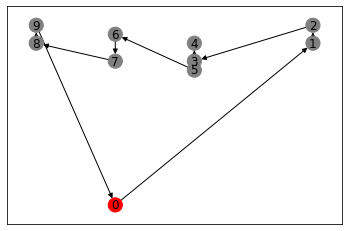

In [40]:
if __name__ == "__main__":
    ## generate data randomly
    data=GetData()
    random_data = data.generate_locations(num_points=10,map_size=100) 
    dismatrix = data.get_euclidean_distance_matrix(random_data.locations)
    print(dismatrix)  # get dismatrix randomly

    ## read solomon data
    path = 'F:/海上风电运维/gurobi申请/VRPTW/c101.txt'
    solomon_data = data.read_solomon(path,customerNum=9) 
    solomon_data_dismatrix = data.get_euclidean_distance_matrix(solomon_data.locations) 
    print(solomon_data_dismatrix)

    ## plot function 
    # data.plot_nodes(solomon_data.locations)
    route = list(range(10))
    route.append(0)
    data.plot_route(solomon_data.locations,route) 

In [50]:
from itertools import combinations
import os,sys,copy
import numpy as np
import time
import matplotlib.pyplot as plt
#from GetData import * 

In [56]:
class Tabu():
    def __init__(self,disMatrix,max_iters=50,maxTabuSize=10):
        """parameters definition"""
        self.disMatrix = disMatrix
        self.maxTabuSize = maxTabuSize
        self.max_iters = max_iters
        self.tabu_list=[]

    def get_route_distance(self,route):
        '''
        Description: function to calculate total distance of a route. evaluate function.
        parameters: route : list
        return : total distance : folat
        '''        
        routes = [0] + route + [0]    # add the start and end point 
        total_distance = 0
        for i,n in enumerate(routes):
            if i != 0 :
                total_distance = total_distance +  self.disMatrix[last_pos][n] 
            last_pos = n
        return total_distance

    def exchange(self,s1,s2,arr):
        """
        function to Swap positions of two elements in an arr
        Args: int,int,list
            s1 : target 1 
            s2 : target 2  
            arr : target array 
        Ouput: list
            current_list : target array 
        """
        current_list = copy.deepcopy(arr)
        index1 , index2 = current_list.index(s1) , current_list.index(s2)  # get index
        current_list[index1], current_list[index2]= arr[index2] , arr[index1]
        return current_list

    def generate_initial_solution(self,num=10,mode='greedy'):
        """
        function to get the initial solution,there two different way to generate route_init.
        Args: 
            num :  int
                the number of points 
            mode : string
                "greedy" : advance step by choosing optimal one 
                "random" : randomly generate a series number
        Ouput: list
            s_init : initial solution route_init
        """
        if mode == 'greedy':
            route_init=[0]
            for i in range(num):
                best_distance = 10000000
                for j in range(num+1):
                    if self.disMatrix[i][j] < best_distance and j not in route_init:  
                        best_distance = self.disMatrix[i][j]
                        best_candidate = j
                route_init.append(best_candidate)
            route_init.remove(0)
                            
        if mode == 'random':
            route_init = np.arange(1,num+1)  #init solution from 1 to num
            np.random.shuffle(route_init)  #shuffle the list randomly

        return list(route_init)

    def tabu_search(self,s_init):   
        """tabu search"""
        s_best = s_init 
        bestCandidate = copy.deepcopy(s_best)
        routes , temp_tabu = [] , []   # init
        routes.append(s_best)
        while(self.max_iters):
            self.max_iters -= 1 # Number of iterations
            neighbors = copy.deepcopy(s_best)
            for s in combinations(neighbors, 2):   
                sCandidate = self.exchange(s[0],s[1],neighbors)  # exchange number to generate candidates
                if s not in self.tabu_list and self.get_route_distance(sCandidate) < self.get_route_distance(bestCandidate):
                    bestCandidate = sCandidate
                    temp_tabu = s                           
            if self.get_route_distance(bestCandidate) < self.get_route_distance(s_best): # record the best solution 
                s_best = bestCandidate
            if  temp_tabu not in self.tabu_list:
                self.tabu_list.append(temp_tabu)
            if len(self.tabu_list) > self.maxTabuSize :
                self.tabu_list.pop(0)
            routes.append(bestCandidate)
        return s_best, routes 

init route :  [2, 1, 6, 3, 4, 5, 7, 10, 8, 9]
init distance :  400
best route :  [3, 1, 9, 8, 4, 5, 10, 7, 6, 2]
best best_distance :  214
the time cost :  0.0050220489501953125


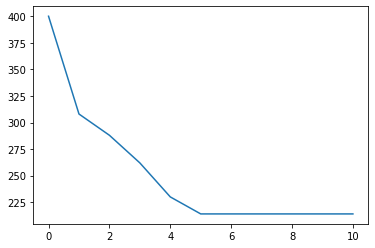

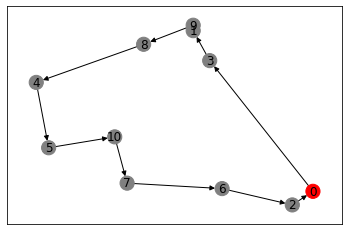

In [61]:
if __name__ == "__main__":
    np.random.seed(2020)
    customerNum = 10  # 定义多少个点
    data=GetData()
    tsp_data = data.generate_locations(num_points=customerNum+1,map_size=100)  #在100*100的图中，随机生成位置，customerNum+1 多一个depot点
    dismatrix = data.get_euclidean_distance_matrix(tsp_data.locations)

    """ Tabu : 
        disMatrix : the distance matrix from 0 to X , 0 represernt starting and stopping point。 
        for example:   disMatrix = [[0,3,4,...
        							 1,0,5,...
        							 3,5,0,...]]
       that means the distance from 0 to 0 is 0, from 0 to 1 is 3,... from 1 to 3 is 5....		
        max_iters : maximum iterations 
        maxTabuSize : maximum iterations 
    """
    tsp = Tabu(disMatrix=dismatrix ,max_iters=10,maxTabuSize=10) 
    # two different way to generate initial solution
    # num : the number of points   
    s_init = tsp.generate_initial_solution(num=customerNum,mode='greedy') # mode = "greedy"  or "random"
    print('init route : ' , s_init)
    print('init distance : ' , tsp.get_route_distance(s_init))

    start = time.time()
    best_route , routes = tsp.tabu_search(s_init)     # tabu search
    end = time.time()

    print('best route : ' , best_route)
    print('best best_distance : ' , tsp.get_route_distance(best_route))
    print('the time cost : ',end - start )

    # plot the result changes with iterations
    results=[]
    for i in routes:
        results.append(tsp.get_route_distance(i))    
    plt.plot(np.arange(len(results)) , results)
    plt.show()
    # plot the route
    data.plot_route(tsp_data.locations,[0]+best_route+[0])

# 元启发式算法 | 遗传算法(GA)解决TSP问题

In [54]:
import numpy as np
import random,time
import matplotlib.pyplot as plt
# from GetData import * 

In [43]:
class GA():

    def __init__(self,disMatrix,MaxGens,pop_size,cross_rate,mutation_rate):
        "pop_size > 1 "
        self.disMatrix = disMatrix
        self.gene_size = len(disMatrix)  # 基因长度,路径长度，0为Depot
        self.pop_size = pop_size     #种群大小，每一代解的数量
        self.MaxGens = MaxGens       #最大迭代次数
        self.cross_rate = cross_rate   #交叉概率
        self.mutation_rate = mutation_rate  #变异概率

    def get_init_solution(self):
        init_routes = np.array([])
        route = np.arange(1,self.gene_size)   # 生成初始解
        for i in range(self.pop_size):
            np.random.shuffle(route)  
            init_routes = np.append(init_routes,route)
        return init_routes.reshape(self.pop_size,self.gene_size-1).astype(int)

    def get_route_distance(self,route):
        routes = list(route)  
        routes = [0] + routes +[0]
        total_distance = 0
        for i,n in enumerate(routes):
            if i != 0 :
                total_distance = total_distance + self.disMatrix[last_pos][n] 
            last_pos = n
        return total_distance

    def get_fitness(self,pop_routes):
        fitness = []
        for route in pop_routes:
            fitness.append(self.get_route_distance(route))
        fitness = 1 - fitness/np.sum(fitness) # 归一化后取反
        return np.array(fitness)

    def select(self,pop_routes):
        fitness = self.get_fitness(pop_routes)
        #轮盘赌的形式进行选择，适应度高的被选中的概率就大
        selected_label = np.random.choice(range(self.pop_size), size=self.pop_size, replace=True, p=fitness/np.sum(fitness))
        return pop_routes[selected_label]

    def crossover(self,pop_routes):
        for i in range(self.pop_size):
            if np.random.rand() < self.cross_rate :    
                obj = pop_routes[np.random.randint(self.pop_size)] #随机选一个交叉对象，也可以选到自己,生成新的一代
                cross_point = np.random.randint(self.gene_size)    #在DNA片段中随机选一个交叉点
                new_one = np.hstack((pop_routes[i][0:cross_point],obj[cross_point::])) #从交叉点往后交换基因片段
                if len(set(new_one)) < self.gene_size-1 :   #交换片段后可能是无效解，即有重复元素,处理一下
                    new_one__ = []
                    for num in new_one:
                        if num not in new_one__:
                            new_one__.append(num)
                        else:
                            for j in range(1,self.gene_size):
                                if j not in new_one__:
                                    new_one__.append(j)
                    pop_routes[i] = new_one__
                    continue
                pop_routes[i] = new_one
        return pop_routes

    def mutate(self,pop_routes):
        for i in range(self.pop_size): 
            if np.random.rand() < self.mutation_rate :
                pos1 = np.random.randint(0,self.gene_size-1)  # 随机选取某一个基因位置发生变异
                pos2 = np.random.randint(0,self.gene_size-1)  
                pop_routes[i][pos1],pop_routes[i][pos2] = pop_routes[i][pos2],pop_routes[i][pos1] #交换位置，完成变异
        return pop_routes

    def ga_evolution(self):
        routes = self.get_init_solution()   #生成初始解
        result=[]  #记录迭代过程中的信息
        while(self.MaxGens):
            self.MaxGens -=1
            routes = self.select(routes)
            routes = self.crossover(routes)
            routes = self.mutate(routes)
            result.append(max(self.get_fitness(routes)))  #记录一下迭代过程中的信息
        plt.plot(range(len(result)),result)
        plt.show()
        idx = np.where(self.get_fitness(routes)==max(self.get_fitness(routes)))   #挑出适应度最大的，可能不止一个
        best_id = random.sample(list(idx[0]), 1)  #从中拿一个
        best_route = routes[best_id]
        return np.squeeze(best_route).tolist()


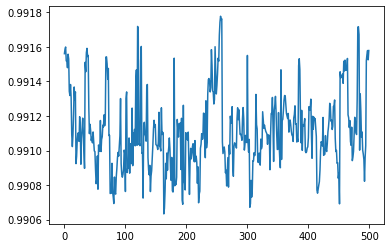

best_route: [5, 3, 1, 2, 4, 6, 7]
best distance: 45


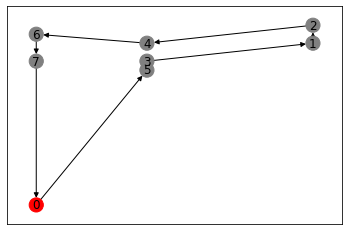

In [44]:
if __name__ == "__main__":
    data=GetData()
    solomon_data = data.read_solomon(path ='F:/海上风电运维/gurobi申请/VRPTW/c101.txt',customerNum=7)  #定义多少个点
    dismatrix = data.get_euclidean_distance_matrix(solomon_data.locations) 

    ga = GA(disMatrix=dismatrix,MaxGens=500,pop_size=100,cross_rate=0.3,mutation_rate=0.1) 
    best_route = ga.ga_evolution()
    print('best_route:',best_route)
    print('best distance:',ga.get_route_distance(best_route))

    data.plot_route(solomon_data.locations,[0]+best_route+[0]) 

# 论文代码复现 | 无人机与卡车联合配送

In [62]:
from __future__ import print_function
from gurobipy import *
import re 
import math 
# from test.pickletester import BigmemPickleTests 
import matplotlib.pyplot as plt
import numpy
import pandas as pd

In [63]:
class Data:
    customerNum = 0 
    nodeNum     = 0 
    range       = 0 
    lunchingTime= 0 
    recoverTime = 0 
    cor_X       = [] 
    cor_Y       = [] 
    demand      = [] 
    serviceTime = [] 
    readyTime   = [] 
    dueTime     = [] 
    disMatrix   = [[]] # 读取数据 

In [68]:
# function to read data from .txt files   
def readData(data, path, customerNum):
    data.customerNum = customerNum 
    data.nodeNum = customerNum + 2 
    f = open(path, 'r') 
    lines = f.readlines() 
    count = 0 
    # read the info
    for line in lines:
        count = count + 1 
        if(count == 2):
            line = line[:-1] 
            str = re.split(r" +", line) 
            data.range = float(str[0]) 
        elif(count == 5):
            line = line[:-1] 
            str = re.split(r" +", line) 
            data.lunchingTime = float(str[0]) 
            data.recoverTime = float(str[1]) 
        elif(count >= 9 and count <= 9 + customerNum): # (count >= 9 and count <= 9 + customerNum)
            line = line[:-1] 
            str = re.split(r" +", line) 
            data.cor_X.append(float(str[2])) 
            data.cor_Y.append(float(str[3])) 
            data.demand.append(float(str[4])) 
            data.readyTime.append(float(str[5])) 
            data.dueTime.append(float(str[6])) 
            data.serviceTime.append(float(str[7])) 

    data.cor_X.append(data.cor_X[0]) 
    data.cor_Y.append(data.cor_Y[0]) 
    data.demand.append(data.demand[0]) 
    data.readyTime.append(data.readyTime[0]) 
    data.dueTime.append(data.dueTime[0]) 
    data.serviceTime.append(data.serviceTime[0]) 
    
            
    # compute the distance matrix
    data.disMatrix = [([0] * data.nodeNum) for p in range(data.nodeNum)]  # 初始化距离矩阵的维度,防止浅拷贝
    # data.disMatrix = [[0] * nodeNum] * nodeNum]  这个是浅拷贝，容易重复
    for i in range(0, data.nodeNum):
        for j in range(0, data.nodeNum):
            temp = (data.cor_X[i] - data.cor_X[j])**2 + (data.cor_Y[i] - data.cor_Y[j])**2 
            data.disMatrix[i][j] = math.sqrt(temp) 
#             if(i == j):
#                 data.disMatrix[i][j] = 0 
            # print("%6.2f" % (math.sqrt(temp)), end = " ") 
            temp = 0 
    
    return data  

In [69]:
def printData(data, customerNum):
    print("下面打印数据\n") 
    print("UAV range = %4d" % data.range) 
    print("UAV lunching time = %4d" % data.lunchingTime) 
    print("UAV recover time = %4d" % data.recoverTime) 
    for i in range(len(data.demand)):
        print('{0}\t{1}\t{2}\t{3}'.format(data.demand[i], data.readyTime[i],data.dueTime[i],  data.serviceTime[i])) 
    
    print("-------距离矩阵-------\n") 
    for i in range(data.nodeNum):
        for j in range(data.nodeNum):
            #print("%d   %d" % (i, j)) 
            print("%6.2f" % (data.disMatrix[i][j]), end = " ") 
        print()  

In [66]:
class Solution:
    ObjVal = 0 
    X = [[]] 
    Y = [[[]]] 
    U = [] 
    P = [] 
    T = [] 
    Tt = [] 
    route_Truck = [] 
    route_UAV = [] 
    
#     def __init__(self):
#         solution = Solution() 
#         # X_ij
#         solution.X = [[[] for i in range(data.nodeNum)] for j in range(data.nodeNum)]  
#         # Y_ijk
#         solution.Y = [[[[] for k in range(data.nodeNum)] for j in range(data.nodeNum)] for i in range(data.nodeNum)] 
#         # U_i
#         solution.U = [[] for i in range(data.nodeNum)] 
#         # P_ij
#         solution.P = [[[] for j in range(data.nodeNum)] for i in range(data.nodeNum)] 
#         # T_i, T_i'
#         solution.T = [[] for i in range(data.nodeNum)] 
#         solution.Tt = [[] for i in range(data.nodeNum)] 
#         return solution 
    
    def getSolution(self, data, model):
        solution = Solution() 
        solution.ObjVal = model.ObjVal 
        # X_ij
        solution.X = [([0] * data.nodeNum) for j in range(data.nodeNum)]  
        # Y_ijk
        solution.Y = [[([0] * data.nodeNum) for j in range(data.nodeNum)] for i in range(data.nodeNum)] 
        # U_i
        solution.U = [[0] for i in range(data.nodeNum)] 
        # P_ij
        solution.P = [[[0] for j in range(data.nodeNum)] for i in range(data.nodeNum)] 
        # T_i, T_i'
        solution.T = [[0] for i in range(data.nodeNum)] 
        solution.Tt = [[0] for i in range(data.nodeNum)] 
        
        a = U[0].x 
        for m in model.getVars():
            str = re.split(r"_", m.VarName) 
            if(str[0] == "X" and m.x == 1):
                solution.X[int(str[1])][int(str[2])] = m.x 
                print(str, end = "") 
                print(" = %d" % m.x) 
            elif(str[0] == "Y" and m.x == 1):
                solution.Y[int(str[1])][int(str[2])][int(str[3])] = m.x 
            elif(str[0] == "U" and m.x > 0) :
                solution.U[int(str[1])] = m.x 
            elif(str[0] == "T" and m.x > 0):
                solution.T[int(str[1])] = m.x  
            elif(str[0] == "Tt" and m.x > 0):
                solution.Tt[int(str[1])] = m.x 
            elif(str[0] == "P" and m.x > 0):
                solution.P[int(str[1])][int(str[2])] = m.x   
        
        # get the route of truck and UAV
        j = 0 
        for i in range(data.nodeNum):
            i = j   # note that the variable is whether is a local variable or a global variable
            # print("i = %d, j = %d" % (i, j), end = "        ") 
            for j in range(data.nodeNum):
                if(solution.X[i][j] == 1):
                    solution.route_Truck.append(i) 
                    print(" %d -" % i, end = " ") 
                    # print("   i = %d, j = %d" % (i, j)) 
                    break 
        print(" 0")  
        solution.route_Truck.append(0) 

        print("\n\n ------Route of UAV ------- ") 
        count = 0 
        for i in range(data.nodeNum):
            for j in range(data.nodeNum):
                for k in range(data.nodeNum):
                    if(solution.Y[i][j][k] == 1):
                        count  = count + 1 
                        #print("UAV %d : %d - %d - %d" % (count, i, j, k))    
                        temp = [i, j, k] 
                        solution.route_UAV.append(temp) 
        
        for i in range(len(solution.route_Truck)):
            print(" %d " %  solution.route_Truck[i], end = " ") 
        print() 
        
        print("\n\n ------Route of UAV ------- ") 
        for i in range(len(solution.route_UAV)):
            for j in range(len(solution.route_UAV[0])):
                print("UAV %d : %d - %d - %d" % (i, solution.route_UAV[i][0], solution.route_UAV[i][1], solution.route_UAV[i][2]))    

        # print(solution.route_UAV)     
        
        return solution   

In [70]:
# reading data
data = Data()  
path = 'F:/海上风电运维/gurobi申请/VRPTW/c101.txt' 

customerNum = 10  
readData(data, path, customerNum) 
printData(data, customerNum) 

ValueError: could not convert string to float: 

In [71]:
# =========build the model===========
big_M = 10000 
# construct the model object
model = Model("FSTSP") 

# Initialize variables
# create variables: Muiti-dimension vector: from inner to outer
# X_ij
X = [[[] for i in range(data.nodeNum)] for j in range(data.nodeNum)]  

# Y_ijk
Y = [[[[] for k in range(data.nodeNum)] for j in range(data.nodeNum)] for i in range(data.nodeNum)] 

# U_i
U = [[] for i in range(data.nodeNum)] 

# P_ij
P = [[[] for j in range(data.nodeNum)] for i in range(data.nodeNum)] 

# T_i, T_i'
T = [[] for i in range(data.nodeNum)] 
Tt = [[] for i in range(data.nodeNum)] 

for i in range(data.nodeNum):
    name1 = 'U_' + str(i) 
    name2 = 'T_' + str(i) 
    name3 = 'Tt_' + str(i) 
    U[i] = model.addVar(0, data.nodeNum, vtype = GRB.CONTINUOUS, name = name1) 
    T[i] = model.addVar(0, big_M, vtype = GRB.CONTINUOUS, name = name2) 
    Tt[i] = model.addVar(0, big_M, vtype = GRB.CONTINUOUS, name = name3) 
    for j in range(data.nodeNum):
        name4 = 'X_' + str(i) + "_"+ str(j) 
        name5 = 'P_' + str(i) + "_" + str(j) 
        X[i][j] = model.addVar(0, 1, vtype = GRB.BINARY, name = name4) 
        P[i][j] = model.addVar(0, 1, vtype = GRB.BINARY, name = name5) 
        for k in range(data.nodeNum):
            name6 = 'Y_' + str(i) + "_" + str(j) + "_" + str(k) 
            Y[i][j][k] = model.addVar(0, 1, vtype = GRB.BINARY, name = name6) 

# Add constraints
# create the objective expression(1)
obj = LinExpr(0) 
            
# add the objective function into the model        
model.setObjective(T[data.nodeNum - 1], GRB.MINIMIZE) 

# constraint (2)
for j in range(1, data.nodeNum - 1): # 这里需要注意，i的取值范围，否则可能会加入空约束 
    expr = LinExpr(0) 
    for i in range(0, data.nodeNum - 1): # i -- N0
        if(i != j):
            expr.addTerms(1, X[i][j]) 
            for k in range(1, data.nodeNum): # k -- N+
                if(i != k and j != k):
                    expr.addTerms(1, Y[i][j][k]) 

    model.addConstr(expr == 1, "c1") 
    expr.clear() 
        

# constraint (3)
expr = LinExpr(0) 
for j in range(1, data.nodeNum):
    expr.addTerms(1, X[0][j]) 
model.addConstr(expr == 1, "c2") 
expr.clear() 

# constraint (4)
expr = LinExpr(0) 
for i in range(data.nodeNum - 1):
    expr.addTerms(1, X[i][data.nodeNum - 1]) 
model.addConstr(expr == 1.0, "c3") 
expr.clear() 

# constraint (5)
for i in range(1, data.nodeNum - 1):
    for j in range(1, data.nodeNum):
        if(i != j):
            model.addConstr(U[i] - U[j] + 1 <= big_M  - big_M * X[i][j], 'c5') 
            
   
# constraint (6)
for j in range(1, data.nodeNum - 1):
    expr1 = LinExpr(0) 
    expr2 = LinExpr(0) 
    for i in range(0, data.nodeNum - 1):
        if(j != i):
            expr1.addTerms(1, X[i][j]) 
               
    for k in range(1, data.nodeNum):
        if(j != k):
            expr2.addTerms(1, X[j][k]) 
               
    model.addConstr(expr1 == expr2, "c6") 
    expr1.clear() 
    expr2.clear() 

# constraint (7)
for i in range(data.nodeNum - 1):
    expr = LinExpr(0) 
    for j in range(1, data.nodeNum - 1):
        if(i != j ):
            for k in range(1, data.nodeNum):
                if(i != k and j != k):
                    expr.addTerms(1, Y[i][j][k]) 
    model.addConstr(expr <= 1, 'c7') 
    expr.clear()         

# constraint (8)
for k in range(1, data.nodeNum):
    expr = LinExpr(0) 
    for i in range(0, data.nodeNum - 1):
        if(i != k ):
            for j in range(1, data.nodeNum - 1):
                if(j != i and j != k):
                    expr.addTerms(1, Y[i][j][k]) 
    model.addConstr(expr <= 1, 'c8') 
    expr.clear() 
    
# constraint (9)
for i in range(1, data.nodeNum - 1):
    for j in range(1, data.nodeNum):
        for k in range(1, data.nodeNum):
            if(i != j and i != k and j != k):
                expr1 = LinExpr(0) 
                expr2 = LinExpr(0) 
                for h in range(data.nodeNum - 1):
                    if(h != i):
                        expr1.addTerms(1, X[h][i]) 
                for l in range(1, data.nodeNum - 1):
                    if(l != k):
                        expr2.addTerms(1, X[l][k]) 
                model.addConstr(2 * Y[i][j][k] <= expr1 + expr2, "c9") 
                expr1.clear() 
                expr2.clear() 

# constraint (10)
for j in range(1, data.nodeNum - 1):
    for k in range(1, data.nodeNum):
        if(j != k):
            expr = LinExpr(0) 
            for h in range(1, data.nodeNum - 1):
                expr.addTerms(1, X[h][k]) 
            model.addConstr(Y[0][j][k] <= expr, "c10") 
            expr.clear() 

# constraint (11)
for i in range(1, data.nodeNum - 1):
    for k in range(1, data.nodeNum):
        if(k != i):
            expr = LinExpr(0) 
            for j in range(1, data.nodeNum - 1):
                if(i != j and j != k):
                    expr.addTerms(big_M, Y[i][j][k]) 
            model.addConstr(U[k] - U[i] >= 1 - big_M + expr, "c11") 
            expr.clear() 

# constraint (12)
for i in range(1, data.nodeNum - 1):
    expr = LinExpr(0) 
    for j in range(1, data.nodeNum - 1):
        for k in range(1, data.nodeNum):
            if(j != i and i != k and j != k):
                expr.addTerms(big_M, Y[i][j][k]) 
    model.addConstr(Tt[i] >= T[i] - big_M + expr, "c12") 
    expr.clear() 

# constraint (13)
for i in range(1, data.nodeNum - 1):
    expr = LinExpr(0) 
    for j in range(1, data.nodeNum - 1):
        for k in range(1, data.nodeNum):
            if(j != i and i != k and j != k):
                expr.addTerms(big_M, Y[i][j][k]) 
    model.addConstr(Tt[i] <= T[i] + big_M - expr, "c13") 
    expr.clear() 

# constraint (14)
for k in range(1, data.nodeNum):
    expr = LinExpr(0) 
    for i in range(0, data.nodeNum - 1):
        for j in range(1, data.nodeNum - 1):
            if(j != i and i != k and j != k):
                expr.addTerms(big_M, Y[i][j][k]) 
    model.addConstr(Tt[k] >= T[k] - big_M + expr, "c14") 
    expr.clear()             

# constraint (15)
for k in range(1, data.nodeNum):
    expr = LinExpr(0) 
    for i in range(0, data.nodeNum - 1):
        for j in range(1, data.nodeNum - 1):
            if(j != i and i != k and j != k):
                expr.addTerms(big_M, Y[i][j][k]) 
    model.addConstr(Tt[k] <= T[k] + big_M - expr, "c15") 
    expr.clear()    

# constraint (16)
for h in range(data.nodeNum - 1):
    for k in range(1, data.nodeNum):
        if(h != k):
            expr1 = LinExpr(0) 
            expr2 = LinExpr(0) 
            for l in range(1, data.nodeNum - 1):
                for m in range(1, data.nodeNum):
                    if(k != l and k != m and l != m):
                        expr1.addTerms(data.lunchingTime, Y[k][l][m]) 
            
            for i in range(data.nodeNum - 1):
                for j in range(1, data.nodeNum - 1):
                    if(i != j and i != k and j != k):
                        expr2.addTerms(data.recoverTime, Y[i][j][k]) 
            model.addConstr(T[k] >= T[h] + data.disMatrix[h][k] + expr1 + expr2 - big_M + big_M * X[h][k], "c16") 
            expr1.clear() 
            expr2.clear() 

# constraint (17)
for j in range(1, data.nodeNum - 1):
    for i in range(data.nodeNum - 1):
        if(i != j):
            expr = LinExpr(0) 
            for k in range(1, data.nodeNum):
                if(i != k and j != k):
                    expr.addTerms(big_M, Y[i][j][k]) 
            model.addConstr(Tt[j] >= Tt[i] + data.disMatrix[i][j] - big_M + expr, "c17") 
            expr.clear() 

# constraint (18)
for j in range(1, data.nodeNum - 1):
    for k in range(1, data.nodeNum):
        if(k != j):
            expr = LinExpr(0) 
            for i in range(data.nodeNum - 1):
                if(i != k and i != j):
                    expr.addTerms(big_M, Y[i][j][k]) 
            model.addConstr(Tt[k] >= Tt[j] + data.disMatrix[j][k] + data.recoverTime - big_M + expr, "c18") 
            expr.clear() 

# constraint (19)
for k in range(1, data.nodeNum):
    for j in range(1, data.nodeNum - 1):
        for i in range(data.nodeNum - 1):
            if(i != j and i != k and j != k):
                model.addConstr(Tt[k] - Tt[j] + data.disMatrix[i][j] <= data.range + big_M - big_M * Y[i][j][k], "c19") 

# constraint (20)
for i in range(1, data.nodeNum - 1):
    for j in range(1, data.nodeNum - 1):
        if(i != j):
            model.addConstr(U[i] - U[j] >= 1 - big_M * P[i][j], "c20") 

# constraint (21)
for i in range(1, data.nodeNum - 1):
    for j in range(1, data.nodeNum - 1):
        if(i != j):
            model.addConstr(U[i] - U[j] <= -1 +big_M - big_M * P[i][j], "c21") 

# constraint (22)
for i in range(1, data.nodeNum - 1):
    for j in range(1, data.nodeNum - 1):
        if(i != j):
            model.addConstr(P[i][j] + P[j][i] == 1, "c22") 

# constraint (23)
for i in range(data.nodeNum - 1):
    for k in range(1, data.nodeNum):
        for l in range(1, data.nodeNum - 1):
            if(k != i and l != i and l != k):
                expr1 = LinExpr(0) 
                expr2 = LinExpr(0) 
                for j in range(1, data.nodeNum - 1):
                    if(k != j and i != j):
                        expr1.addTerms(big_M, Y[i][j][k]) 
                for m in range(1, data.nodeNum - 1):
                    for n in range(1, data.nodeNum):
                        if(l != m and l != n and m != n):
                            expr2.addTerms(big_M, Y[l][m][n]) 
                model.addConstr(Tt[l] >= Tt[k] - 3*big_M + expr1 + expr2 + big_M * P[i][l], "c23") 
                expr1.clear() 
                expr2.clear() 

# constraint (24)
model.addConstr(T[0] == 0, "c24") 

# constraint (25)
model.addConstr(Tt[0] == 0, "c25") 

# constraint (26)
for j in range(1, data.nodeNum - 1):
    model.addConstr(P[0][j] == 1, "c26") 

# constraint (27)
for i in range(data.nodeNum):
    for j in range(data.nodeNum):
        if(i == j):
            model.addConstr(X[i][j] == 0, "c27") 
        for k in range(data.nodeNum):
            if(i == j or i == k or k == j):
                model.addConstr(Y[i][j][k] == 0, "c28") 
                      

# solve the problem
model.write('a.lp')
model.Params.timelimit = 3600 
model.optimize() 


# get the solution info
solution = Solution() 
solution = solution.getSolution(data, model) 
print("\n\n\n\n-----optimal value-----")
print("Obj: %g" % solution.ObjVal) 
print("\n\n ------Route of truck------") 
# print("Truck: ", end = " ") 
j = 0 
for i in range(data.nodeNum):
    i = j   # note that the variable is whether is a local variable or a global variable
    # print("i = %d, j = %d" % (i, j), end = "        ") 
    for j in range(data.nodeNum):
        if(solution.X[i][j] == 1):
            print(" %d -" % i, end = " ") 
            # print("   i = %d, j = %d" % (i, j)) 
            break 
print(" 0")  

print("\n\n ------Route of UAV ------- ") 
count = 0 
for i in range(data.nodeNum):
    for j in range(data.nodeNum):
        for k in range(data.nodeNum):
            if(solution.Y[i][j][k] == 1):
                count  = count + 1 
                print("UAV %d : %d - %d - %d" % (count, i, j, k))  

IndexError: list index out of range

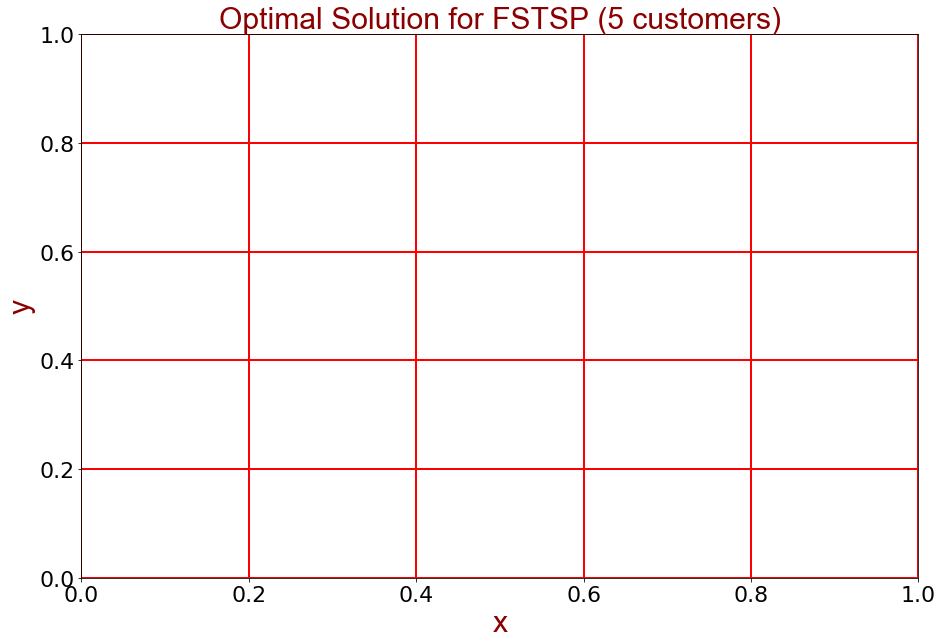

In [72]:
fig = plt.figure(figsize=(15,10)) 
font_dict = {'family': 'Arial',   # serif
         'style': 'normal',   # 'italic',
         'weight': 'normal',
        'color':  'darkred', 
        'size': 30,
        }
font_dict2 = {'family': 'Arial',   # serif
         'style': 'normal',   # 'italQic',
         'weight': 'normal',
        'color':  'darkred', 
        'size': 24,
        }
plt.xlabel('x', font_dict) 
plt.ylabel('y', font_dict)
plt.title('Optimal Solution for FSTSP (5 customers)', font_dict)  
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)    # plt.yticks(fontsize=30) 
plt.grid(True, color='r', linestyle='-', linewidth=2) 

In [73]:
plt.scatter(data.cor_X[0], data.cor_Y[0], c='blue', alpha=1, marker=',', linewidths=5, label='depot')
plt.scatter(data.cor_X[1:-1], data.cor_Y[1:-1], c='magenta', alpha=1, marker='o', linewidths=5, label='customer') 
# c='red'定义为红色，alpha是透明度，marker是画的样式

IndexError: list index out of range

In [74]:
# draw the route
for i in range(data.nodeNum):
    for j in range(data.nodeNum):
        if(solution.X[i][j] == 1):
            x = [data.cor_X[i], data.cor_X[j]] 
            y = [data.cor_Y[i], data.cor_Y[j]] 
            plt.plot(x, y, 'b', linewidth = 3) 
#             plt.text(data.cor_X[i]-1, data.cor_Y[i], str(i), fontsize=15, color = 'black')
#             plt.text(coverage50index*0.98, 4, coverage50index, fontsize=10, color = 'red')  
            plt.text(data.cor_X[i]-0.2, data.cor_Y[i], str(i), fontdict = font_dict2) 

for i in range(data.nodeNum):
    for j in range(data.nodeNum):
        for k in range(data.nodeNum):
            if(solution.Y[i][j][k] == 1):
                x = [data.cor_X[i], data.cor_X[j], data.cor_X[k]] 
                y = [data.cor_Y[i], data.cor_Y[j], data.cor_Y[k]] 
                plt.plot(x, y, 'r--', linewidth = 3) 
                plt.text(data.cor_X[j]-0.2, data.cor_Y[j], str(j), fontdict = font_dict2)   
                #plt.plot(x, y, 'r--', label = "UAV", linewidth = 3) 
                    
# plt.grid(True)
plt.grid(False)  
plt.legend(loc='best', fontsize = 20) 
plt.show()         

NameError: name 'solution' is not defined

In [77]:
# _*_coding:utf-8 _*_
from __future__ import print_function
from gurobipy import *
import re 
import math 
# from test.pickletester import BigmemPickleTests 
import matplotlib.pyplot as plt
import numpy
import pandas as pd

class Data:
    customerNum = 0 
    nodeNum     = 0 
    range       = 0 
    lunchingTime= 0 
    recoverTime = 0 
    cor_X       = [] 
    cor_Y       = [] 
    demand      = [] 
    serviceTime = [] 
    readyTime   = [] 
    dueTime     = [] 
    disMatrix   = [[]] # 读取数据
    
# function to read data from .txt files   
def readData(data, path, customerNum):
    data.customerNum = customerNum 
    data.nodeNum = customerNum + 2 
    f = open(path, 'r') 
    lines = f.readlines() 
    count = 0 
    # read the info
    for line in lines:
        count = count + 1 
        if(count == 2):
            line = line[:-1] 
            str = re.split(r" +", line) 
            data.range = float(str[0]) 
        elif(count == 5):
            line = line[:-1] 
            str = re.split(r" +", line) 
            data.lunchingTime = float(str[0]) 
            data.recoverTime = float(str[1]) 
        elif(count >= 9 and count <= 9 + customerNum): # (count >= 9 and count <= 9 + customerNum)
            line = line[:-1] 
            str = re.split(r" +", line) 
            data.cor_X.append(float(str[2])) 
            data.cor_Y.append(float(str[3])) 
            data.demand.append(float(str[4])) 
            data.readyTime.append(float(str[5])) 
            data.dueTime.append(float(str[6])) 
            data.serviceTime.append(float(str[7])) 

    data.cor_X.append(data.cor_X[0]) 
    data.cor_Y.append(data.cor_Y[0]) 
    data.demand.append(data.demand[0]) 
    data.readyTime.append(data.readyTime[0]) 
    data.dueTime.append(data.dueTime[0]) 
    data.serviceTime.append(data.serviceTime[0]) 
    
            
    # compute the distance matrix
    data.disMatrix = [([0] * data.nodeNum) for p in range(data.nodeNum)]  # 初始化距离矩阵的维度,防止浅拷贝
    # data.disMatrix = [[0] * nodeNum] * nodeNum]  这个是浅拷贝，容易重复
    for i in range(0, data.nodeNum):
        for j in range(0, data.nodeNum):
            temp = (data.cor_X[i] - data.cor_X[j])**2 + (data.cor_Y[i] - data.cor_Y[j])**2 
            data.disMatrix[i][j] = math.sqrt(temp) 
#             if(i == j):
#                 data.disMatrix[i][j] = 0 
            # print("%6.2f" % (math.sqrt(temp)), end = " ") 
            temp = 0 
    
    return data 
            
        
def printData(data, customerNum):
    print("下面打印数据\n") 
    print("UAV range = %4d" % data.range) 
    print("UAV lunching time = %4d" % data.lunchingTime) 
    print("UAV recover time = %4d" % data.recoverTime) 
    for i in range(len(data.demand)):
        print('{0}\t{1}\t{2}\t{3}'.format(data.demand[i], data.readyTime[i],data.dueTime[i],  data.serviceTime[i])) 
    
    print("-------距离矩阵-------\n") 
    for i in range(data.nodeNum):
        for j in range(data.nodeNum):
            #print("%d   %d" % (i, j)) 
            print("%6.2f" % (data.disMatrix[i][j]), end = " ") 
        print() 

class Solution:
    ObjVal = 0 
    X = [[]] 
    Y = [[[]]] 
    U = [] 
    P = [] 
    T = [] 
    Tt = [] 
    route_Truck = [] 
    route_UAV = [] 
    
#     def __init__(self):
#         solution = Solution() 
#         # X_ij
#         solution.X = [[[] for i in range(data.nodeNum)] for j in range(data.nodeNum)]  
#         # Y_ijk
#         solution.Y = [[[[] for k in range(data.nodeNum)] for j in range(data.nodeNum)] for i in range(data.nodeNum)] 
#         # U_i
#         solution.U = [[] for i in range(data.nodeNum)] 
#         # P_ij
#         solution.P = [[[] for j in range(data.nodeNum)] for i in range(data.nodeNum)] 
#         # T_i, T_i'
#         solution.T = [[] for i in range(data.nodeNum)] 
#         solution.Tt = [[] for i in range(data.nodeNum)] 
#         return solution 
    
    def getSolution(self, data, model):
        solution = Solution() 
        solution.ObjVal = model.ObjVal 
        # X_ij
        solution.X = [([0] * data.nodeNum) for j in range(data.nodeNum)]  
        # Y_ijk
        solution.Y = [[([0] * data.nodeNum) for j in range(data.nodeNum)] for i in range(data.nodeNum)] 
        # U_i
        solution.U = [[0] for i in range(data.nodeNum)] 
        # P_ij
        solution.P = [[[0] for j in range(data.nodeNum)] for i in range(data.nodeNum)] 
        # T_i, T_i'
        solution.T = [[0] for i in range(data.nodeNum)] 
        solution.Tt = [[0] for i in range(data.nodeNum)] 
        
        a = U[0].x 
        for m in model.getVars():
            str = re.split(r"_", m.VarName) 
            if(str[0] == "X" and m.x == 1):
                solution.X[int(str[1])][int(str[2])] = m.x 
                print(str, end = "") 
                print(" = %d" % m.x) 
            elif(str[0] == "Y" and m.x == 1):
                solution.Y[int(str[1])][int(str[2])][int(str[3])] = m.x 
            elif(str[0] == "U" and m.x > 0) :
                solution.U[int(str[1])] = m.x 
            elif(str[0] == "T" and m.x > 0):
                solution.T[int(str[1])] = m.x  
            elif(str[0] == "Tt" and m.x > 0):
                solution.Tt[int(str[1])] = m.x 
            elif(str[0] == "P" and m.x > 0):
                solution.P[int(str[1])][int(str[2])] = m.x   
        
        # get the route of truck and UAV
        j = 0 
        for i in range(data.nodeNum):
            i = j   # note that the variable is whether is a local variable or a global variable
            # print("i = %d, j = %d" % (i, j), end = "        ") 
            for j in range(data.nodeNum):
                if(solution.X[i][j] == 1):
                    solution.route_Truck.append(i) 
                    print(" %d -" % i, end = " ") 
                    # print("   i = %d, j = %d" % (i, j)) 
                    break 
        print(" 0")  
        solution.route_Truck.append(0) 

        print("\n\n ------Route of UAV ------- ") 
        count = 0 
        for i in range(data.nodeNum):
            for j in range(data.nodeNum):
                for k in range(data.nodeNum):
                    if(solution.Y[i][j][k] == 1):
                        count  = count + 1 
                        #print("UAV %d : %d - %d - %d" % (count, i, j, k))    
                        temp = [i, j, k] 
                        solution.route_UAV.append(temp) 
        
        for i in range(len(solution.route_Truck)):
            print(" %d " %  solution.route_Truck[i], end = " ") 
        print() 
        
        print("\n\n ------Route of UAV ------- ") 
        for i in range(len(solution.route_UAV)):
            for j in range(len(solution.route_UAV[0])):
                print("UAV %d : %d - %d - %d" % (i, solution.route_UAV[i][0], solution.route_UAV[i][1], solution.route_UAV[i][2]))    

        # print(solution.route_UAV)     
        
        return solution  
                
                                                         
# reading data
data = Data() 
path = 'F:/海上风电运维/gurobi申请/VRPTW/c101.txt' 

customerNum = 10  
readData(data, path, customerNum) 
printData(data, customerNum) 


# =========build the model===========
big_M = 10000 
# construct the model object
model = Model("FSTSP") 

# Initialize variables
# create variables: Muiti-dimension vector: from inner to outer
# X_ij
X = [[[] for i in range(data.nodeNum)] for j in range(data.nodeNum)]  

# Y_ijk
Y = [[[[] for k in range(data.nodeNum)] for j in range(data.nodeNum)] for i in range(data.nodeNum)] 

# U_i
U = [[] for i in range(data.nodeNum)] 

# P_ij
P = [[[] for j in range(data.nodeNum)] for i in range(data.nodeNum)] 

# T_i, T_i'
T = [[] for i in range(data.nodeNum)] 
Tt = [[] for i in range(data.nodeNum)] 

for i in range(data.nodeNum):
    name1 = 'U_' + str(i) 
    name2 = 'T_' + str(i) 
    name3 = 'Tt_' + str(i) 
    U[i] = model.addVar(0, data.nodeNum, vtype = GRB.CONTINUOUS, name = name1) 
    T[i] = model.addVar(0, big_M, vtype = GRB.CONTINUOUS, name = name2) 
    Tt[i] = model.addVar(0, big_M, vtype = GRB.CONTINUOUS, name = name3) 
    for j in range(data.nodeNum):
        name4 = 'X_' + str(i) + "_"+ str(j) 
        name5 = 'P_' + str(i) + "_" + str(j) 
        X[i][j] = model.addVar(0, 1, vtype = GRB.BINARY, name = name4) 
        P[i][j] = model.addVar(0, 1, vtype = GRB.BINARY, name = name5) 
        for k in range(data.nodeNum):
            name6 = 'Y_' + str(i) + "_" + str(j) + "_" + str(k) 
            Y[i][j][k] = model.addVar(0, 1, vtype = GRB.BINARY, name = name6) 

# Add constraints
# create the objective expression(1)
obj = LinExpr(0) 
            
# add the objective function into the model        
model.setObjective(T[data.nodeNum - 1], GRB.MINIMIZE) 

# constraint (2)
for j in range(1, data.nodeNum - 1): # 这里需要注意，i的取值范围，否则可能会加入空约束 
    expr = LinExpr(0) 
    for i in range(0, data.nodeNum - 1): # i -- N0
        if(i != j):
            expr.addTerms(1, X[i][j]) 
            for k in range(1, data.nodeNum): # k -- N+
                if(i != k and j != k):
                    expr.addTerms(1, Y[i][j][k]) 

    model.addConstr(expr == 1, "c1") 
    expr.clear() 
        

# constraint (3)
expr = LinExpr(0) 
for j in range(1, data.nodeNum):
    expr.addTerms(1, X[0][j]) 
model.addConstr(expr == 1, "c2") 
expr.clear() 

# constraint (4)
expr = LinExpr(0) 
for i in range(data.nodeNum - 1):
    expr.addTerms(1, X[i][data.nodeNum - 1]) 
model.addConstr(expr == 1.0, "c3") 
expr.clear() 

# constraint (5)
for i in range(1, data.nodeNum - 1):
    for j in range(1, data.nodeNum):
        if(i != j):
            model.addConstr(U[i] - U[j] + 1 <= big_M  - big_M * X[i][j], 'c5') 
            
# constraint (6)
for j in range(1, data.nodeNum - 1):
    expr1 = LinExpr(0) 
    expr2 = LinExpr(0) 
    for i in range(0, data.nodeNum - 1):
        if(j != i):
            expr1.addTerms(1, X[i][j]) 
               
    for k in range(1, data.nodeNum):
        if(j != k):
            expr2.addTerms(1, X[j][k]) 
               
    model.addConstr(expr1 == expr2, "c6") 
    expr1.clear() 
    expr2.clear() 

# constraint (7)
for i in range(data.nodeNum - 1):
    expr = LinExpr(0) 
    for j in range(1, data.nodeNum - 1):
        if(i != j ):
            for k in range(1, data.nodeNum):
                if(i != k and j != k):
                    expr.addTerms(1, Y[i][j][k]) 
    model.addConstr(expr <= 1, 'c7') 
    expr.clear()         

# constraint (8)
for k in range(1, data.nodeNum):
    expr = LinExpr(0) 
    for i in range(0, data.nodeNum - 1):
        if(i != k ):
            for j in range(1, data.nodeNum - 1):
                if(j != i and j != k):
                    expr.addTerms(1, Y[i][j][k]) 
    model.addConstr(expr <= 1, 'c8') 
    expr.clear() 
    
# constraint (9)
for i in range(1, data.nodeNum - 1):
    for j in range(1, data.nodeNum):
        for k in range(1, data.nodeNum):
            if(i != j and i != k and j != k):
                expr1 = LinExpr(0) 
                expr2 = LinExpr(0) 
                for h in range(data.nodeNum - 1):
                    if(h != i):
                        expr1.addTerms(1, X[h][i]) 
                for l in range(1, data.nodeNum - 1):
                    if(l != k):
                        expr2.addTerms(1, X[l][k]) 
                model.addConstr(2 * Y[i][j][k] <= expr1 + expr2, "c9") 
                expr1.clear() 
                expr2.clear() 

# constraint (10)
for j in range(1, data.nodeNum - 1):
    for k in range(1, data.nodeNum):
        if(j != k):
            expr = LinExpr(0) 
            for h in range(1, data.nodeNum - 1):
                expr.addTerms(1, X[h][k]) 
            model.addConstr(Y[0][j][k] <= expr, "c10") 
            expr.clear() 

# constraint (11)
for i in range(1, data.nodeNum - 1):
    for k in range(1, data.nodeNum):
        if(k != i):
            expr = LinExpr(0) 
            for j in range(1, data.nodeNum - 1):
                if(i != j and j != k):
                    expr.addTerms(big_M, Y[i][j][k]) 
            model.addConstr(U[k] - U[i] >= 1 - big_M + expr, "c11") 
            expr.clear() 

# constraint (12)
for i in range(1, data.nodeNum - 1):
    expr = LinExpr(0) 
    for j in range(1, data.nodeNum - 1):
        for k in range(1, data.nodeNum):
            if(j != i and i != k and j != k):
                expr.addTerms(big_M, Y[i][j][k]) 
    model.addConstr(Tt[i] >= T[i] - big_M + expr, "c12") 
    expr.clear() 

# constraint (13)
for i in range(1, data.nodeNum - 1):
    expr = LinExpr(0) 
    for j in range(1, data.nodeNum - 1):
        for k in range(1, data.nodeNum):
            if(j != i and i != k and j != k):
                expr.addTerms(big_M, Y[i][j][k]) 
    model.addConstr(Tt[i] <= T[i] + big_M - expr, "c13") 
    expr.clear() 

# constraint (14)
for k in range(1, data.nodeNum):
    expr = LinExpr(0) 
    for i in range(0, data.nodeNum - 1):
        for j in range(1, data.nodeNum - 1):
            if(j != i and i != k and j != k):
                expr.addTerms(big_M, Y[i][j][k]) 
    model.addConstr(Tt[k] >= T[k] - big_M + expr, "c14") 
    expr.clear()             

# constraint (15)
for k in range(1, data.nodeNum):
    expr = LinExpr(0) 
    for i in range(0, data.nodeNum - 1):
        for j in range(1, data.nodeNum - 1):
            if(j != i and i != k and j != k):
                expr.addTerms(big_M, Y[i][j][k]) 
    model.addConstr(Tt[k] <= T[k] + big_M - expr, "c15") 
    expr.clear()    

# constraint (16)
for h in range(data.nodeNum - 1):
    for k in range(1, data.nodeNum):
        if(h != k):
            expr1 = LinExpr(0) 
            expr2 = LinExpr(0) 
            for l in range(1, data.nodeNum - 1):
                for m in range(1, data.nodeNum):
                    if(k != l and k != m and l != m):
                        expr1.addTerms(data.lunchingTime, Y[k][l][m]) 
            
            for i in range(data.nodeNum - 1):
                for j in range(1, data.nodeNum - 1):
                    if(i != j and i != k and j != k):
                        expr2.addTerms(data.recoverTime, Y[i][j][k]) 
            model.addConstr(T[k] >= T[h] + data.disMatrix[h][k] + expr1 + expr2 - big_M + big_M * X[h][k], "c16") 
            expr1.clear() 
            expr2.clear() 

# constraint (17)
for j in range(1, data.nodeNum - 1):
    for i in range(data.nodeNum - 1):
        if(i != j):
            expr = LinExpr(0) 
            for k in range(1, data.nodeNum):
                if(i != k and j != k):
                    expr.addTerms(big_M, Y[i][j][k]) 
            model.addConstr(Tt[j] >= Tt[i] + data.disMatrix[i][j] - big_M + expr, "c17") 
            expr.clear() 

# constraint (18)
for j in range(1, data.nodeNum - 1):
    for k in range(1, data.nodeNum):
        if(k != j):
            expr = LinExpr(0) 
            for i in range(data.nodeNum - 1):
                if(i != k and i != j):
                    expr.addTerms(big_M, Y[i][j][k]) 
            model.addConstr(Tt[k] >= Tt[j] + data.disMatrix[j][k] + data.recoverTime - big_M + expr, "c18") 
            expr.clear() 

# constraint (19)
for k in range(1, data.nodeNum):
    for j in range(1, data.nodeNum - 1):
        for i in range(data.nodeNum - 1):
            if(i != j and i != k and j != k):
                model.addConstr(Tt[k] - Tt[j] + data.disMatrix[i][j] <= data.range + big_M - big_M * Y[i][j][k], "c19") 

# constraint (20)
for i in range(1, data.nodeNum - 1):
    for j in range(1, data.nodeNum - 1):
        if(i != j):
            model.addConstr(U[i] - U[j] >= 1 - big_M * P[i][j], "c20") 

# constraint (21)
for i in range(1, data.nodeNum - 1):
    for j in range(1, data.nodeNum - 1):
        if(i != j):
            model.addConstr(U[i] - U[j] <= -1 +big_M - big_M * P[i][j], "c21") 

# constraint (22)
for i in range(1, data.nodeNum - 1):
    for j in range(1, data.nodeNum - 1):
        if(i != j):
            model.addConstr(P[i][j] + P[j][i] == 1, "c22") 

# constraint (23)
for i in range(data.nodeNum - 1):
    for k in range(1, data.nodeNum):
        for l in range(1, data.nodeNum - 1):
            if(k != i and l != i and l != k):
                expr1 = LinExpr(0) 
                expr2 = LinExpr(0) 
                for j in range(1, data.nodeNum - 1):
                    if(k != j and i != j):
                        expr1.addTerms(big_M, Y[i][j][k]) 
                for m in range(1, data.nodeNum - 1):
                    for n in range(1, data.nodeNum):
                        if(l != m and l != n and m != n):
                            expr2.addTerms(big_M, Y[l][m][n]) 
                model.addConstr(Tt[l] >= Tt[k] - 3*big_M + expr1 + expr2 + big_M * P[i][l], "c23") 
                expr1.clear() 
                expr2.clear() 

# constraint (24)
model.addConstr(T[0] == 0, "c24") 

# constraint (25)
model.addConstr(Tt[0] == 0, "c25") 

# constraint (26)
for j in range(1, data.nodeNum - 1):
    model.addConstr(P[0][j] == 1, "c26") 

# constraint (27)
for i in range(data.nodeNum):
    for j in range(data.nodeNum):
        if(i == j):
            model.addConstr(X[i][j] == 0, "c27") 
        for k in range(data.nodeNum):
            if(i == j or i == k or k == j):
                model.addConstr(Y[i][j][k] == 0, "c28") 
                      

# solve the problem
model.write('a.lp')
model.Params.timelimit = 3600 
model.optimize() 


# get the solution info
solution = Solution() 
solution = solution.getSolution(data, model) 
print("\n\n\n\n-----optimal value-----")
print("Obj: %g" % solution.ObjVal) 
print("\n\n ------Route of truck------") 
# print("Truck: ", end = " ") 
j = 0 
for i in range(data.nodeNum):
    i = j   # note that the variable is whether is a local variable or a global variable
    # print("i = %d, j = %d" % (i, j), end = "        ") 
    for j in range(data.nodeNum):
        if(solution.X[i][j] == 1):
            print(" %d -" % i, end = " ") 
            # print("   i = %d, j = %d" % (i, j)) 
            break 
print(" 0")  

print("\n\n ------Route of UAV ------- ") 
count = 0 
for i in range(data.nodeNum):
    for j in range(data.nodeNum):
        for k in range(data.nodeNum):
            if(solution.Y[i][j][k] == 1):
                count  = count + 1 
                print("UAV %d : %d - %d - %d" % (count, i, j, k)) 


# draw the route graph
# draw all the nodes first
# data1 = Data() 
# readData(data1, path, 100) 
fig = plt.figure(figsize=(15,10)) 
font_dict = {'family': 'Arial',   # serif
         'style': 'normal',   # 'italic',
         'weight': 'normal',
        'color':  'darkred', 
        'size': 30,
        }
font_dict2 = {'family': 'Arial',   # serif
         'style': 'normal',   # 'italQic',
         'weight': 'normal',
        'color':  'darkred', 
        'size': 24,
        }
plt.xlabel('x', font_dict) 
plt.ylabel('y', font_dict)
plt.title('Optimal Solution for FSTSP (5 customers)', font_dict)  
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)    # plt.yticks(fontsize=30) 
plt.grid(True, color='r', linestyle='-', linewidth=2)


'''
marker='o'
marker=','
marker='.'
marker=(9, 3, 30)
marker='+'
marker='v'
marker='^'
marker='<'
marker='>'
marker='1'
marker='2'
marker='3'
red        blue        green
'''
plt.scatter(data.cor_X[0], data.cor_Y[0], c='blue', alpha=1, marker=',', linewidths=5, label='depot')
plt.scatter(data.cor_X[1:-1], data.cor_Y[1:-1], c='magenta', alpha=1, marker='o', linewidths=5, label='customer') # c='red'定义为红色，alpha是透明度，marker是画的样式

# draw the route
for i in range(data.nodeNum):
    for j in range(data.nodeNum):
        if(solution.X[i][j] == 1):
            x = [data.cor_X[i], data.cor_X[j]] 
            y = [data.cor_Y[i], data.cor_Y[j]] 
            plt.plot(x, y, 'b', linewidth = 3) 
#             plt.text(data.cor_X[i]-1, data.cor_Y[i], str(i), fontsize=15, color = 'black')
#             plt.text(coverage50index*0.98, 4, coverage50index, fontsize=10, color = 'red')  
            plt.text(data.cor_X[i]-0.2, data.cor_Y[i], str(i), fontdict = font_dict2) 

for i in range(data.nodeNum):
    for j in range(data.nodeNum):
        for k in range(data.nodeNum):
            if(solution.Y[i][j][k] == 1):
                x = [data.cor_X[i], data.cor_X[j], data.cor_X[k]] 
                y = [data.cor_Y[i], data.cor_Y[j], data.cor_Y[k]] 
                plt.plot(x, y, 'r--', linewidth = 3) 
                plt.text(data.cor_X[j]-0.2, data.cor_Y[j], str(j), fontdict = font_dict2)   
                #plt.plot(x, y, 'r--', label = "UAV", linewidth = 3) 
                    
# plt.grid(True)
plt.grid(False)  
plt.legend(loc='best', fontsize = 20) 
plt.show()               

ValueError: could not convert string to float: 